# Imports and General Settings

In [2]:
import tensorflow as tf
import tensorflow.contrib as tf_contrib

import os
import pathlib

import numpy as np

import io

import random

import pylab
import tfplot

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tfx
import tensorflow_transform as tft

from cleverhans.loss import SNNLCrossEntropy

# import self utility functions
import util.model_arch_utility as model_arch
import util.log_utility as log_util
import util.data_augmentation_utility as da_util
import util.load_data_utility as load_data_util

# tensorflow specific settings
tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.DEBUG)

# which GPU to be used (0 is RTX, 1 or 2 are either of the Titan Xps)
gpu = "/GPU:2"

AUTOTUNE = tf.contrib.data.AUTOTUNE

session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True
session_config.allow_soft_placement = True

# session_config.log_device_placement = True
tf.keras.backend.set_session(tf.Session(config=session_config))

# make sure tensorflow-gpu is being used
print(tf.test.gpu_device_name())

/device:GPU:0


# Data Augmentation

In [6]:
# data augmentation methods in data_augmentation_utility.py

# choose augmentation in load_data_utility.py

# ResNet-10

## Architecture

In [3]:
num_classes = 2

# ResNet-10 architecture
def resnet_network(x, num_channels=8, n_classes=num_classes, reuse = False, is_training = True):
    with tf.variable_scope('ConvNet', reuse = reuse), tf.device(gpu):
        
        x = tf.reshape(x, shape=[-1, 512, 512, 1])
        # channels
        
        filtered_images = []
        
        filtered_images.append(tf.identity(x))
        
        x = model_arch.conv(x, num_channels, kernel=7, stride=1, padding='SAME')
        
        filtered_images.append(tf.identity(x))
        
        x = model_arch.resblock(x, channels=num_channels, kernel=3, is_training=is_training, 
                      downsample=False, scope='resblock1_id1')      
   
        filtered_images.append(tf.identity(x))

        x = model_arch.resblock(x, channels=num_channels * 2, kernel=3, is_training=is_training, 
                     downsample=True, scope='resblock2_conv1')
        
        filtered_images.append(tf.identity(x))

        x = model_arch.resblock(x, channels=num_channels * 2, kernel=3, is_training=is_training, 
                      downsample=False, scope='resblock3_id2')
        
        filtered_images.append(tf.identity(x))
        
        x = model_arch.resblock(x, channels=num_channels * 4, kernel=3, is_training=is_training, 
                     downsample=True, scope='resblock4_conv2')

        filtered_images.append(tf.identity(x))
        
        x = model_arch.resblock(x, channels=num_channels * 4, kernel=3, is_training=is_training, 
                      downsample=False, scope='resblock5_id3')
        
        filtered_images.append(tf.identity(x))
        
        
        x = model_arch.batch_norm(x, is_training, scope='batch_norm')
        
        x = model_arch.relu(x)
        
        x_pre_flatten = tf.identity(x)
        
        x = model_arch.fully_connected(x, num_classes)
        
        return x, x_pre_flatten, filtered_images

    
def resnet_model_fn(features, labels, mode, num_channels=8, snnl_weight=0.05,
                      log=True):
    with tf.device(gpu):

        print("in gpu part")
        logits_train, activ_maps_train, filtered_images = resnet_network(features,
                                                                          num_channels=num_channels,
                                                                          n_classes=num_classes,
                                                                          reuse=False,
                                                                          is_training=True)
        
        logits_test, activ_maps_test, _ = resnet_network(features,
                                                          num_channels=num_channels,
                                                          n_classes=num_classes,
                                                          reuse=False,
                                                          is_training=True)


        pred_classes = tf.arg_max(logits_test, dimension=1)

        # PREDICT MODE
        if mode == tf.estimator.ModeKeys.PREDICT:

            prediction_dict = {
                'class_ids': pred_classes[:, tf.newaxis],
                'probabilities': tf.nn.softmax(logits_test),
                'logits': logits_test,
            }
            
            return tf.estimator.EstimatorSpec(mode=mode, predictions=prediction_dict)
        

        loss_op = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))

        
        acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
        
        if (not log):
            tf.summary.scalar("loss", loss_op)
            tf.summary.scalar("accuracy", acc_op[1])
        
        if mode == tf.estimator.ModeKeys.TRAIN:
                

            # the different ops for training, evaluating, ...
            estim_specs = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=pred_classes,
                loss=loss_op,
                train_op=train_op,
                eval_metric_ops={'accuracy': acc_op}
            )

            return estim_specs
    
#     for var in tf.trainable_variables():
#         print(var.name)

        if (log):

#             conv0_weights = [v for v in tf.global_variables() if v.name == "Resnet-10/conv_0/conv2d/kernel:0"][0]

#             plot_op_expanded = tf.expand_dims(log_util.plot_conv_weights(conv0_weights), 0)
#             tf.summary.image("conv_0_weight_plots", plot_op_expanded)


            with tf.name_scope("activation_maps"):

                counter = 0

                plot_ops = []

                for filtered_im in filtered_images:

                    name = "after_conv_" + str(counter)
                    if counter == 0:
                        name = "original_image:"
                    
                    activation_map = tf.slice(filtered_im,[0, 0, 0, 0],[1, -1, -1, -1])
                    activation_op = tf.expand_dims(log_util.plot_conv_output(activation_map, name), 0)

                    plot_ops.append(activation_op)

                    counter = counter + 1

                final_log_op = tf.concat(plot_ops, 2)

                tf.summary.image("image_display", final_log_op)
        
        eval_summary_hook = tf.train.SummarySaverHook(
            save_steps=1,
            output_dir=model_path + "/eval_images",
            summary_op=tf.summary.merge_all())
        # Add it to the evaluation_hook list
        evaluation_hooks = []
        evaluation_hooks.append(eval_summary_hook)

        # the different ops for training, evaluating, ...
        estim_specs = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss_op,
            train_op=train_op,
            eval_metric_ops={'accuracy': acc_op},
            evaluation_hooks=evaluation_hooks
        )

        return estim_specs

# Running Results

## Experimentation

In [12]:
tf.logging.set_verbosity(tf.logging.INFO)
tf.summary.FileWriterCache.clear()
b_size = 32

learning_rate = 0.001

random_seed = 777

random.seed(a=random_seed)

num_steps = 10000

# convnet_checkpoint_path_base = "/data/jma/model/dataset_experiments/no_data_aug_no_norm/"

resnet_checkpoint_path_base = "/data/jma/model/resnet10_binary/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

# kernel_sizes = [[10, 7, 3]] v1

kernel_sizes = [[10, 7, 3, 3]]
filter_sizes = [16]
snnl_weights = [0.0]


dataset_root = "./data/generated_splits/2class/"

# sets = ["ali_relabeled_original", "peter_relabeled_original", "ali_relabeled_undersampled", "peter_relabeled_undersampled"]

sets = ["ali_relabeled_original"]

for dt_set in sets:
    for filter_size in filter_sizes:
        for kernel_size in kernel_sizes:

            for snnl_weight in snnl_weights:

                train_root = dataset_root + dt_set + "/train/"
                eval_root = dataset_root + dt_set + "/eval/"
               
                train_paths = load_data_util.load_image_paths(train_root)
                random.shuffle(train_paths)

                print(train_root)
                
                eval_paths = load_data_util.load_image_paths(eval_root)
                
                train_input_fn = lambda : load_data_util.load(train_root, train_paths, training=True, augment=False, batch_size=32, norm=False, shuffle=False)
                eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, norm=False, shuffle=False)


                model_path = resnet_checkpoint_path_base + dt_set + "_filter" + str(filter_size)+"_snnl" + str(snnl_weight) + "/"
                print(model_path)

                config = tf.estimator.RunConfig(
                    log_step_count_steps= 20,
                    save_summary_steps= 30,
                    save_checkpoints_secs= 30,
                    model_dir=model_path,
                    tf_random_seed=random_seed,
                    session_config=session_config)

                model_fn = lambda features, labels, mode: resnet_model_fn(features, labels, mode, 
                                                                             num_channels=filter_size,
                                                                            snnl_weight=snnl_weight,
                                                                            log=False)

                model = tf.estimator.Estimator(model_fn=model_fn, config=config)

                train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=num_steps)
                eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn, throttle_secs=30)

                tf.estimator.train_and_evaluate(model, train_spec, eval_spec)

        

./data/generated_splits/2class/ali_relabeled_original/train/
/data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/', '_tf_random_seed': 777, '_save_summary_steps': 30, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 30, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 20, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f13f4713630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training 

INFO:tensorflow:Finished evaluation at 2019-09-24-20:44:09
INFO:tensorflow:Saving dict for global step 342: accuracy = 0.8151659, global_step = 342, loss = 20.010422
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 342: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-342
INFO:tensorflow:global_step/sec: 1.43617
INFO:tensorflow:loss = 0.0, step = 360 (13.928 sec)
INFO:tensorflow:global_step/sec: 2.27686
INFO:tensorflow:loss = 0.0, step = 380 (8.782 sec)
INFO:tensorflow:Saving checkpoints for 398 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-20:44:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-398
INFO:tensorflow:Running local_init_

INFO:tensorflow:global_step/sec: 2.24836
INFO:tensorflow:loss = 0.0, step = 760 (8.896 sec)
INFO:tensorflow:global_step/sec: 2.19625
INFO:tensorflow:loss = 0.0, step = 780 (9.109 sec)
INFO:tensorflow:Saving checkpoints for 793 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-20:48:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-793
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-20:48:11
INFO:tensorflow:Saving dict for global step 793: accuracy = 0.8151659, global_step = 793, loss = 21.718954
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 793: /data/jma/model/resnet10_binary/ali_rela

pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-20:51:39
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-1188
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-20:51:42
INFO:tensorflow:Saving dict for global step 1188: accuracy = 0.8151659, global_step = 1188, loss = 21.71832
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1188: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-1188
INFO:tensorflow:global_step/sec: 1.45174
INFO:tensorflow:loss = 0.0, step = 1200 (13.776 sec)
INFO:tensorflow:global_step/sec: 2.2041
INFO:tensorflow:loss = 0.0, step = 1220 (9.073 sec)
INFO:tensorflow:global_step/sec: 2.25045
INFO:tensorflow:loss = 0.0, step = 124

INFO:tensorflow:global_step/sec: 2.13156
INFO:tensorflow:loss = 2.9802308e-08, step = 1640 (9.382 sec)
INFO:tensorflow:Saving checkpoints for 1649 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-20:55:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-1649
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-20:55:43
INFO:tensorflow:Saving dict for global step 1649: accuracy = 0.8151659, global_step = 1649, loss = 21.717184
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1649: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-1649
INFO:tensorflow:global_step/

in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-20:59:12
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-2044
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-20:59:15
INFO:tensorflow:Saving dict for global step 2044: accuracy = 0.8151659, global_step = 2044, loss = 21.715857
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2044: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-2044
INFO:tensorflow:global_step/sec: 1.4498
INFO:tensorflow:loss = 0.0, step = 2060 (13.794 sec)
INFO:tensorflow:global_step/sec: 2.28764
INFO:tensorflow:loss = 0.0, step = 2080 (8.744 sec)
INFO:tensorflow:Saving checkpoints for 2101 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.

INFO:tensorflow:Finished evaluation at 2019-09-24-21:02:46
INFO:tensorflow:Saving dict for global step 2441: accuracy = 0.8151659, global_step = 2441, loss = 21.714216
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2441: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-2441
INFO:tensorflow:global_step/sec: 1.45259
INFO:tensorflow:loss = 0.0, step = 2440 (13.768 sec)
INFO:tensorflow:global_step/sec: 2.27177
INFO:tensorflow:loss = 3.6880155e-07, step = 2460 (8.805 sec)
INFO:tensorflow:global_step/sec: 2.16935
INFO:tensorflow:loss = 0.0, step = 2480 (9.218 sec)
INFO:tensorflow:Saving checkpoints for 2498 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-21:03:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/mo

in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-21:08:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-3130
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-21:08:49
INFO:tensorflow:Saving dict for global step 3130: accuracy = 0.8151659, global_step = 3130, loss = 21.710337
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3130: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-3130
INFO:tensorflow:global_step/sec: 1.4693
INFO:tensorflow:loss = 0.0, step = 3140 (13.611 sec)
INFO:tensorflow:global_step/sec: 2.28356
INFO:tensorflow:loss = 0.0, step = 3160 (8.758 sec)
INFO:tensorflow:global_step/sec: 2.16843
INFO:tensorflow:loss = 0.0, step = 3180 (9.226 sec)
INFO:tensorflow:Saving checkpoints

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-21:12:21
INFO:tensorflow:Saving dict for global step 3527: accuracy = 0.8151659, global_step = 3527, loss = 21.707582
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3527: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-3527
INFO:tensorflow:global_step/sec: 1.44414
INFO:tensorflow:loss = 0.0, step = 3540 (13.851 sec)
INFO:tensorflow:global_step/sec: 2.21373
INFO:tensorflow:loss = 0.0, step = 3560 (9.033 sec)
INFO:tensorflow:global_step/sec: 2.27641
INFO:tensorflow:loss = 0.0, step = 3580 (8.786 sec)
INFO:tensorflow:Saving checkpoints for 3583 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-21:12:48
INFO:tensorflow:Gr

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3924: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-3924
INFO:tensorflow:global_step/sec: 1.4525
INFO:tensorflow:loss = 0.0, step = 3940 (13.769 sec)
INFO:tensorflow:global_step/sec: 2.28351
INFO:tensorflow:loss = 0.0, step = 3960 (8.760 sec)
INFO:tensorflow:Saving checkpoints for 3981 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-21:16:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-3981
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-21:16:23
INFO:tensorflow:Saving dict for global step 3981: accu

INFO:tensorflow:global_step/sec: 2.18031
INFO:tensorflow:loss = 0.0, step = 4360 (9.173 sec)
INFO:tensorflow:Saving checkpoints for 4378 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-21:19:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-4378
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-21:19:54
INFO:tensorflow:Saving dict for global step 4378: accuracy = 0.8151659, global_step = 4378, loss = 21.699842
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4378: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-4378
INFO:tensorflow:global_step/sec: 1.454

INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-21:23:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-4774
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-21:23:26
INFO:tensorflow:Saving dict for global step 4774: accuracy = 0.8151659, global_step = 4774, loss = 21.695227
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4774: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-4774
INFO:tensorflow:global_step/sec: 1.45537
INFO:tensorflow:loss = 0.0, step = 4780 (13.741 sec)
INFO:tensorflow:global_step/sec: 2.27096
INFO:tensorflow:loss = 0.0, step = 4800 (8.808 sec)
INFO:tensorflow:global_step/sec: 2.20089
INFO:tensorflow:loss = 0.0, step = 4820 (9.088 sec)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-21:26:58
INFO:tensorflow:Saving dict for global step 5170: accuracy = 0.8151659, global_step = 5170, loss = 21.690256
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5170: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-5170
INFO:tensorflow:global_step/sec: 1.48386
INFO:tensorflow:loss = 0.0, step = 5180 (13.479 sec)
INFO:tensorflow:global_step/sec: 2.12233
INFO:tensorflow:loss = 0.0, step = 5200 (9.422 sec)
INFO:tensorflow:global_step/sec: 2.19968
INFO:tensorflow:loss = 0.0, step = 5220 (9.093 sec)
INFO:tensorflow:Saving checkpoints for 5225 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-21:27:25
INFO:tensorflow:Gr

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5564: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-5564
INFO:tensorflow:global_step/sec: 1.4201
INFO:tensorflow:loss = 0.0, step = 5580 (14.083 sec)
INFO:tensorflow:global_step/sec: 2.30916
INFO:tensorflow:loss = 0.0, step = 5600 (8.660 sec)
INFO:tensorflow:Saving checkpoints for 5620 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-21:30:56
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-5620
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-21:30:59
INFO:tensorflow:Saving dict for global step 5620: accu

INFO:tensorflow:global_step/sec: 2.16844
INFO:tensorflow:loss = 0.0, step = 6000 (9.223 sec)
INFO:tensorflow:Saving checkpoints for 6017 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-21:34:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-6017
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-21:34:31
INFO:tensorflow:Saving dict for global step 6017: accuracy = 0.8151659, global_step = 6017, loss = 21.67758
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6017: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-6017
INFO:tensorflow:global_step/sec: 1.4682

in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-21:37:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-6413
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-21:38:02
INFO:tensorflow:Saving dict for global step 6413: accuracy = 0.8151659, global_step = 6413, loss = 21.67082
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6413: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-6413
INFO:tensorflow:global_step/sec: 1.44336
INFO:tensorflow:loss = 0.0, step = 6420 (13.858 sec)
INFO:tensorflow:global_step/sec: 2.31025
INFO:tensorflow:loss = 0.0, step = 6440 (8.656 sec)
INFO:tensorflow:global_step/sec: 2.13495
INFO:tensorflow:loss = 0.0, step = 6460 (9.368 sec)
INFO:tensorflow:Saving checkpoints

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-21:41:34
INFO:tensorflow:Saving dict for global step 6810: accuracy = 0.8151659, global_step = 6810, loss = 21.663498
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6810: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-6810
INFO:tensorflow:global_step/sec: 1.46619
INFO:tensorflow:loss = 0.0, step = 6820 (13.641 sec)
INFO:tensorflow:global_step/sec: 2.18565
INFO:tensorflow:loss = 0.0, step = 6840 (9.151 sec)
INFO:tensorflow:global_step/sec: 2.2101
INFO:tensorflow:loss = 0.0, step = 6860 (9.048 sec)
INFO:tensorflow:Saving checkpoints for 6867 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-21:42:01
INFO:tensorflow:Gra

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7206: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-7206
INFO:tensorflow:global_step/sec: 1.45809
INFO:tensorflow:loss = 0.0, step = 7220 (13.716 sec)
INFO:tensorflow:global_step/sec: 2.25465
INFO:tensorflow:loss = 0.0, step = 7240 (8.872 sec)
INFO:tensorflow:global_step/sec: 2.16876
INFO:tensorflow:loss = 0.0, step = 7260 (9.221 sec)
INFO:tensorflow:Saving checkpoints for 7263 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-21:45:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-7263
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Fin

INFO:tensorflow:global_step/sec: 2.19408
INFO:tensorflow:loss = 0.0, step = 7640 (9.114 sec)
INFO:tensorflow:Saving checkpoints for 7658 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
INFO:tensorflow:Skip the current checkpoint eval due to throttle secs (30 secs).
INFO:tensorflow:global_step/sec: 2.18561
INFO:tensorflow:loss = 0.0, step = 7660 (9.149 sec)
INFO:tensorflow:global_step/sec: 2.13682
INFO:tensorflow:loss = 0.0, step = 7680 (9.360 sec)
INFO:tensorflow:global_step/sec: 2.16758
INFO:tensorflow:loss = 0.0, step = 7700 (9.228 sec)
INFO:tensorflow:global_step/sec: 2.25703
INFO:tensorflow:loss = 0.0, step = 7720 (8.860 sec)
INFO:tensorflow:Saving checkpoints for 7724 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-21:49:35
INFO:tensorflow:Graph was fin

INFO:tensorflow:global_step/sec: 1.44088
INFO:tensorflow:loss = 0.0, step = 8080 (13.881 sec)
INFO:tensorflow:global_step/sec: 2.26399
INFO:tensorflow:loss = 8.195628e-08, step = 8100 (8.835 sec)
INFO:tensorflow:Saving checkpoints for 8120 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-21:53:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-8120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-21:53:09
INFO:tensorflow:Saving dict for global step 8120: accuracy = 0.8151659, global_step = 8120, loss = 21.636332
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8120: /data/jma/model/resnet1

pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-21:56:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-8518
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-21:56:41
INFO:tensorflow:Saving dict for global step 8518: accuracy = 0.8151659, global_step = 8518, loss = 21.627748
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8518: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-8518
INFO:tensorflow:global_step/sec: 1.46054
INFO:tensorflow:loss = 0.0, step = 8520 (13.693 sec)
INFO:tensorflow:global_step/sec: 2.19025
INFO:tensorflow:loss = 0.0, step = 8540 (9.131 sec)
INFO:tensorflow:global_step/sec: 2.22752
INFO:tensorflow:loss = 0.0, step = 8

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-22:00:13
INFO:tensorflow:Saving dict for global step 8915: accuracy = 0.8151659, global_step = 8915, loss = 21.618164
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8915: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-8915
INFO:tensorflow:global_step/sec: 1.43889
INFO:tensorflow:loss = 0.0, step = 8920 (13.900 sec)
INFO:tensorflow:global_step/sec: 2.28185
INFO:tensorflow:loss = 0.0, step = 8940 (8.766 sec)
INFO:tensorflow:global_step/sec: 2.21272
INFO:tensorflow:loss = 0.0, step = 8960 (9.039 sec)
INFO:tensorflow:Saving checkpoints for 8972 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-22:00:40
INFO:tensorflow:Gr

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9311: /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-9311
INFO:tensorflow:global_step/sec: 1.47969
INFO:tensorflow:loss = 0.0, step = 9320 (13.515 sec)
INFO:tensorflow:global_step/sec: 2.18028
INFO:tensorflow:loss = 0.0, step = 9340 (9.173 sec)
INFO:tensorflow:global_step/sec: 2.21626
INFO:tensorflow:loss = 0.0, step = 9360 (9.025 sec)
INFO:tensorflow:Saving checkpoints for 9367 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-22:04:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-9367
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Fin

INFO:tensorflow:global_step/sec: 2.30767
INFO:tensorflow:loss = 0.0, step = 9740 (8.668 sec)
INFO:tensorflow:global_step/sec: 2.09135
INFO:tensorflow:loss = 0.0, step = 9760 (9.562 sec)
INFO:tensorflow:Saving checkpoints for 9763 into /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt.
pre-processing
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-24-22:07:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/model.ckpt-9763
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-24-22:07:46
INFO:tensorflow:Saving dict for global step 9763: accuracy = 0.8151659, global_step = 9763, loss = 21.597837
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9763: /data/jma/model/resnet10_binary/a

## Evaluation

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)

b_size = 32

learning_rate = 0.005

random_seed = 777

num_steps = 20000

convnet_checkpoint_path_base = "/data/jma/model/dataset_experiments/no_norm_no_data_aug/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3]]
filter_sizes = [8]
snnl_weights = [0.0]

# data_root = "./data/custom_activation_map_data/"

data_root = "./data/custom_activation_map_data/"

image_paths = load_data_util.load_image_paths(data_root)

eval_input_fn = lambda : load_data_util.load(data_root, image_paths, training=False, augment=False, batch_size=1, shuffle=False)


for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()
 
            model_path = convnet_checkpoint_path_base + "original_new_labels/"
            print(model_path)

            model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                        conv_kernels=kernel_size, 
                                                                        num_channels=filter_size,
                                                                        snnl_weight=snnl_weight,
                                                                        log=True)

            model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

            model.evaluate(eval_input_fn)
              

/data/jma/model/dataset_experiments/no_data_aug/original_new_labels/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/dataset_experiments/no_data_aug/original_new_labels/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdd5fe1d438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Call

# Metrics

## Metric Utility Functions

In [13]:
def path_to_label(paths, data_root):

    print(data_root)
    
    data_root = pathlib.Path(data_root)

    
    
    # return label names
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
    
    # assign index to label
    
    label_to_index = dict((name, index) for index,name in enumerate(label_names))

    print(label_to_index)
    
    # array of all labels corresponding to image_paths
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                        for path in paths]
    
    return all_image_labels



## Confusion Matrices

/data/jma/model/resnet10_binary//ali_relabeled_original_filter16_snnl0.0/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/resnet10_binary//ali_relabeled_original_filter16_snnl0.0/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f14ff042fd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
./data/gen

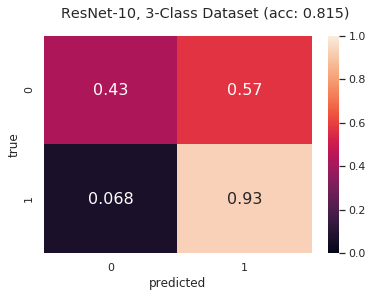

In [18]:
%matplotlib inline

import sklearn

tf.logging.set_verbosity(tf.logging.INFO)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


tf.summary.FileWriterCache.clear()
b_size = 32


random_seed = 777

convnet_checkpoint_path_base = "/data/jma/model/resnet10_binary//"


# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3, 3]]
filter_sizes = [16]
snnl_weights = [0.0]

# data_root = "./data/data_relabeled_png_synthetic/"

# image_paths = load_data_util.load_image_paths(data_root)
# train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed, split=[0.7, 0.1, 0.2])

# train_input_fn = lambda : load_data_util.load(data_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
# eval_input_fn = lambda : load_data_util.load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
# test_input_fn = lambda : load_data_util.load(data_root, test_paths, training=False, augment=False, shuffle=False)



        
dataset_root = "./data/generated_splits/2class/"

# sets = ["ali_relabeled_original", "peter_relabeled_original", "ali_relabeled_undersampled", "peter_relabeled_undersampled"]

# sets = ["ali_relabeled_original", "ali_relabeled_undersampled"]
# set_labels = ["rater1", "rater1_undersampled"]

sets = ["ali_relabeled_original"]
set_labels = ["rater1"]

for dt_set, set_label in zip(sets, set_labels):
    for filter_size in filter_sizes:
        for kernel_size in kernel_sizes:

            for snnl_weight in snnl_weights:

                
                eval_root = dataset_root + dt_set + "/eval/"
                eval_paths = load_data_util.load_image_paths(eval_root)
                
                eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, norm=False, shuffle=False)


                
                model_path = convnet_checkpoint_path_base + dt_set + "_filter" + str(filter_size)+"_snnl" + str(snnl_weight) + "/"
                
                print(model_path)


                model_fn = lambda features, labels, mode: resnet_model_fn(features, labels, mode, 
                                                                             num_channels=filter_size,
                                                                            snnl_weight=snnl_weight,
                                                                            log=False)

                model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

               
                values = model.predict(eval_input_fn)


                original_labels = path_to_label(eval_paths, eval_root)
                predictions = list(values)
                
                
                predicted_labels = [elem['class_ids'][0] for elem in predictions]
                
                accuracy = sklearn.metrics.accuracy_score(original_labels, predicted_labels)
                
                cm = tf.confusion_matrix(original_labels, predicted_labels)
                cm = tf.to_float(cm)

                cm = cm.numpy()

                row_sums = cm.sum(axis=1)
                cm = cm / row_sums[:, np.newaxis]

                df_cm = pd.DataFrame(cm, range(num_classes), range(num_classes))
                #plt.figure(figsize = (10,7))
                
                sns.set(font_scale=1)#for label size
#                 plt.suptitle(set_label + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight) + " (acc: " + str('%.3f'%(accuracy)) + ")")
                plt.suptitle("ResNet-10, 3-Class Dataset (acc: " + str('%.3f'%(accuracy)) + ")")

    
                ax = sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, vmin=0, vmax=1.0)# font size
                ax.set(xlabel='predicted', ylabel='true')
                plt.show()

## Incorrectly Classified Images (PNG Format)

/data/jma/model/cnn_v2_rating2/ali_relabeled_original_filter16_snnl0.0/
./data/generated_splits/3class_rating2/ali_relabeled_original/eval/
{'0': 0, '1': 1, '2': 2}
pre-processing
in gpu part


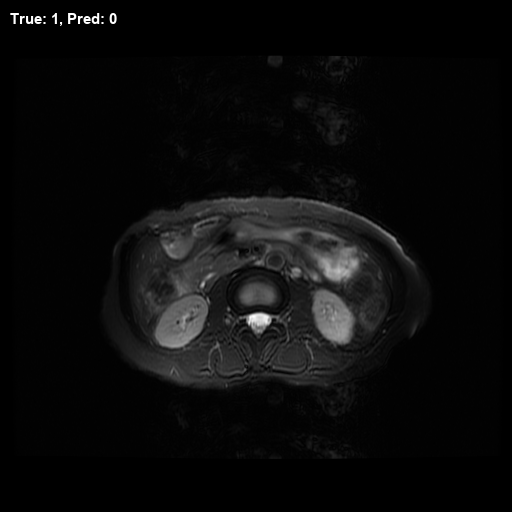

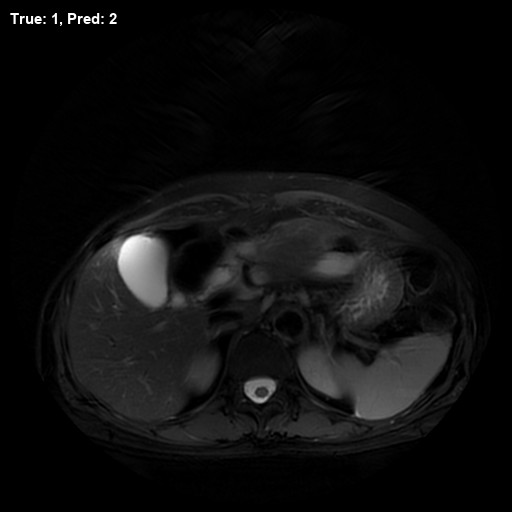

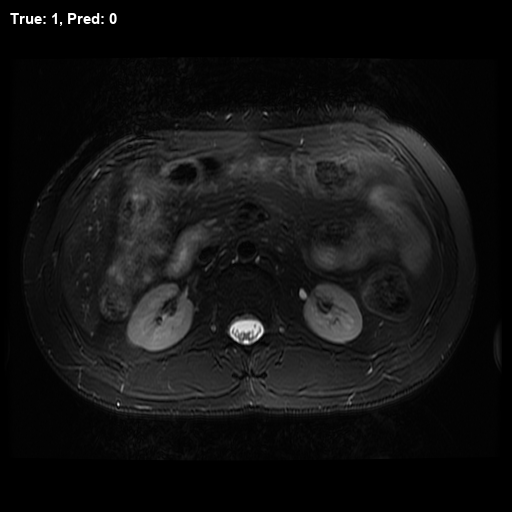

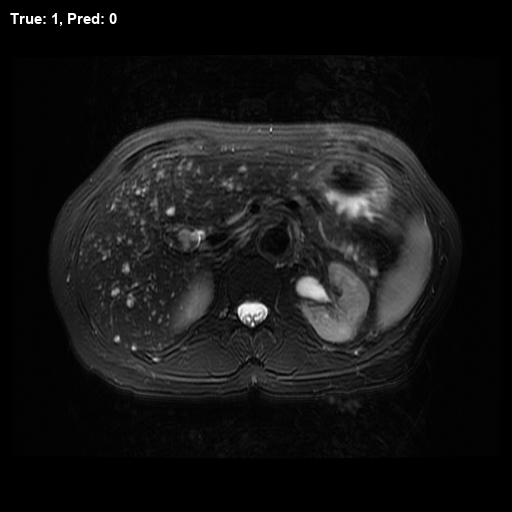

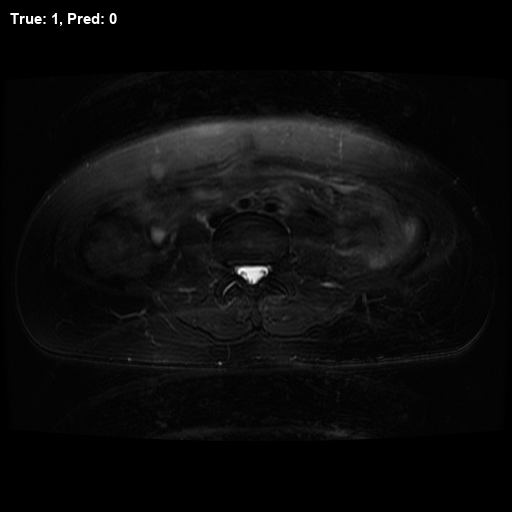

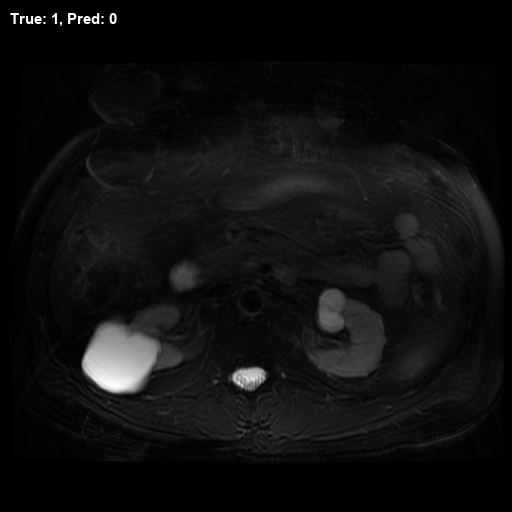

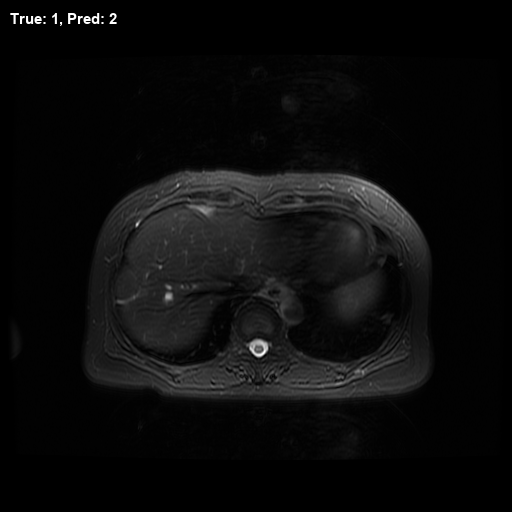

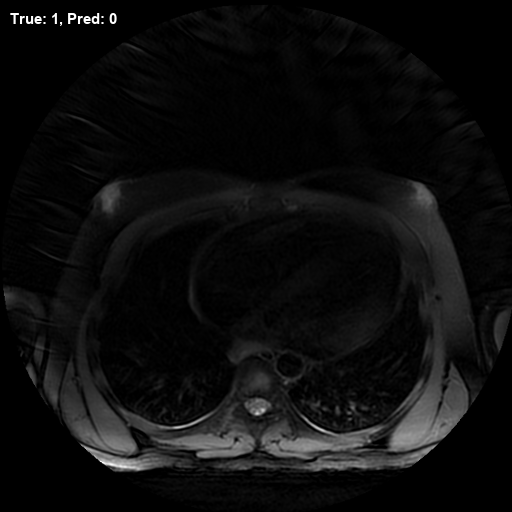

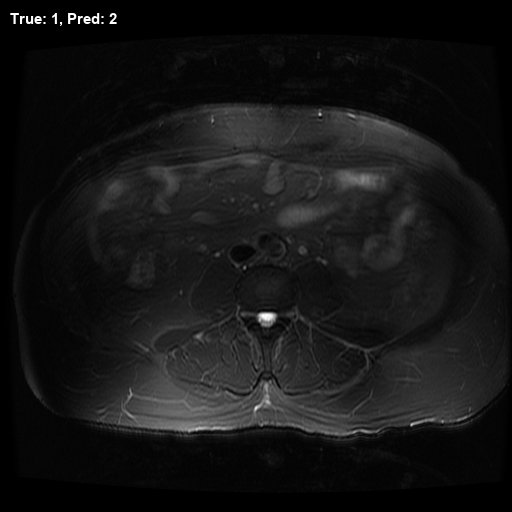

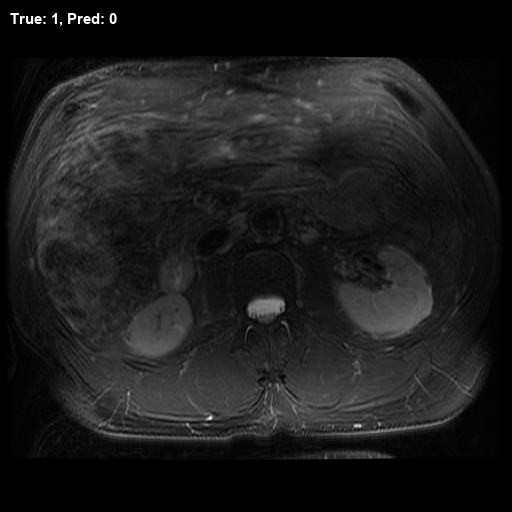

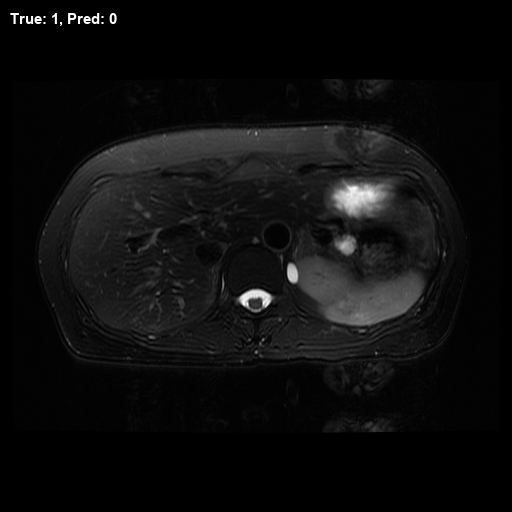

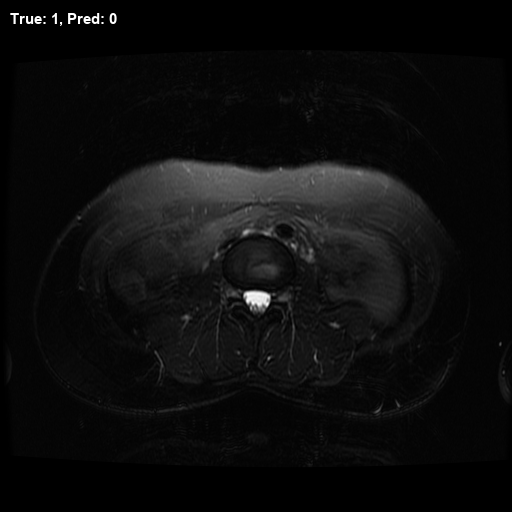

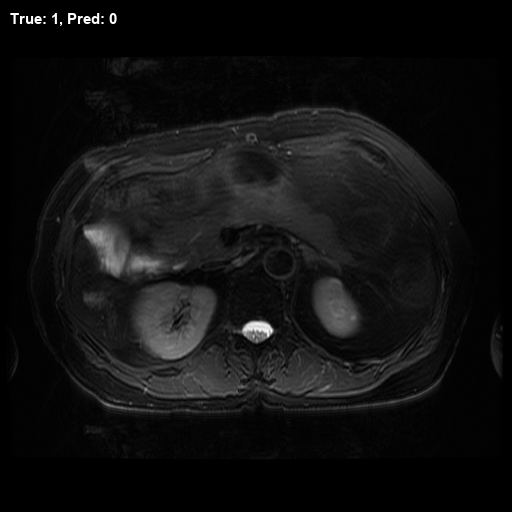

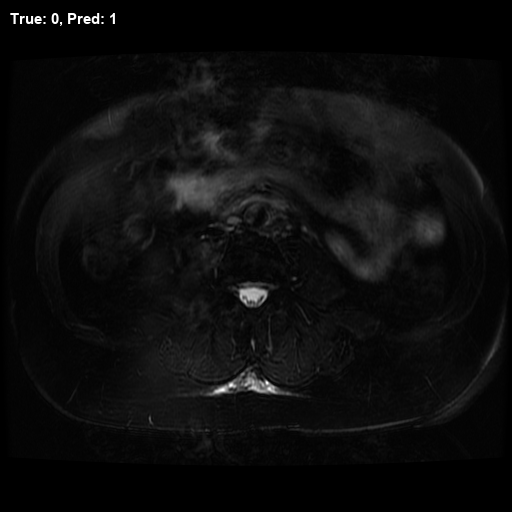

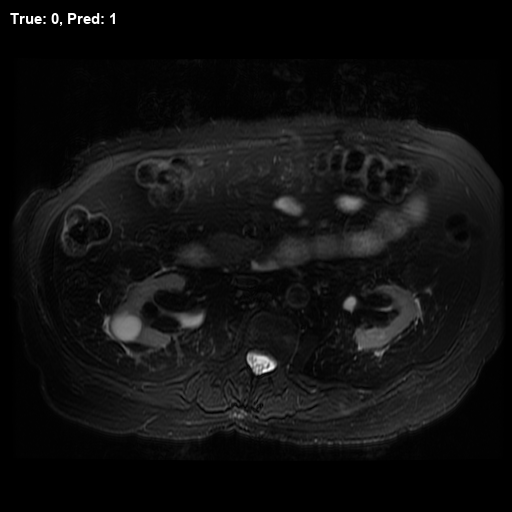

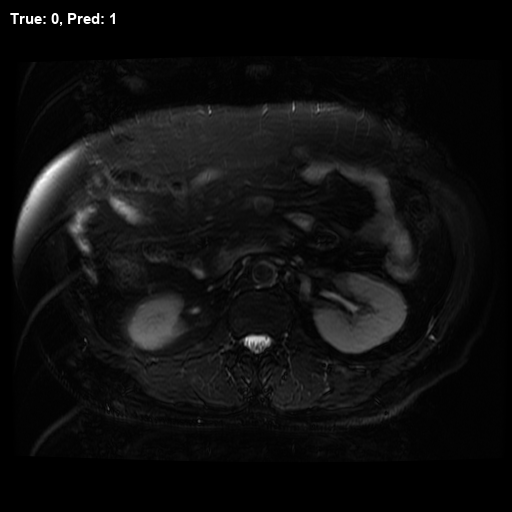

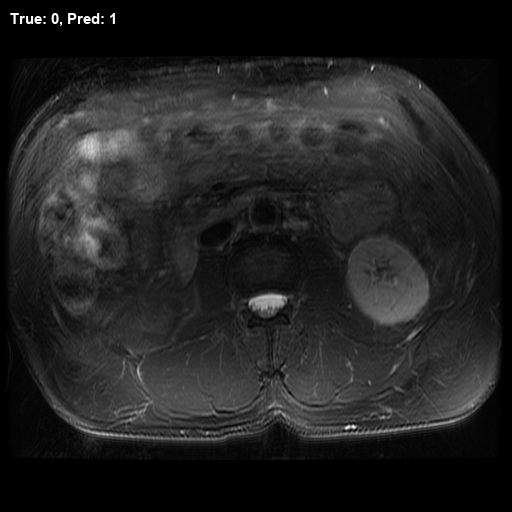

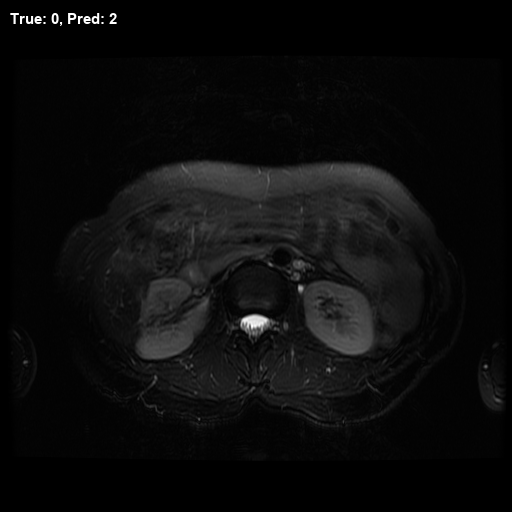

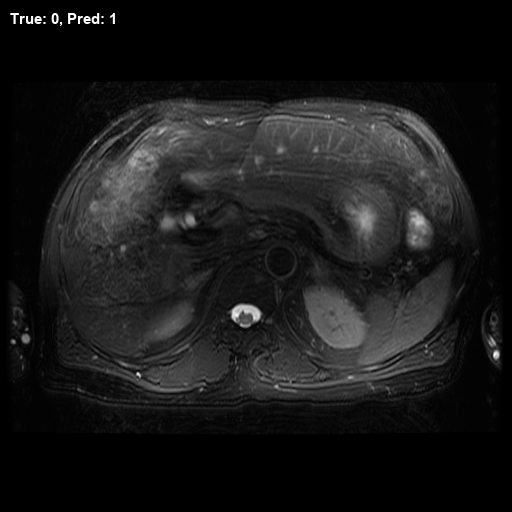

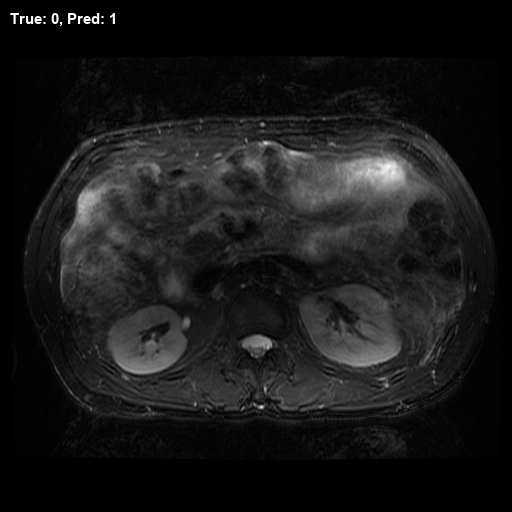

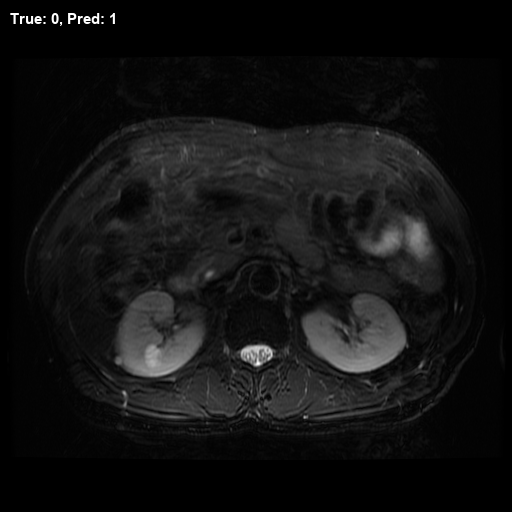

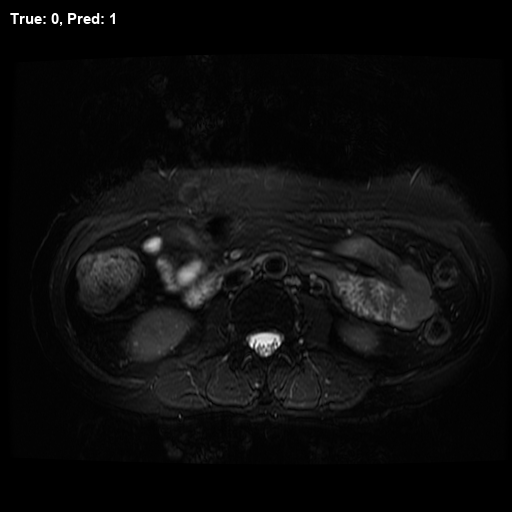

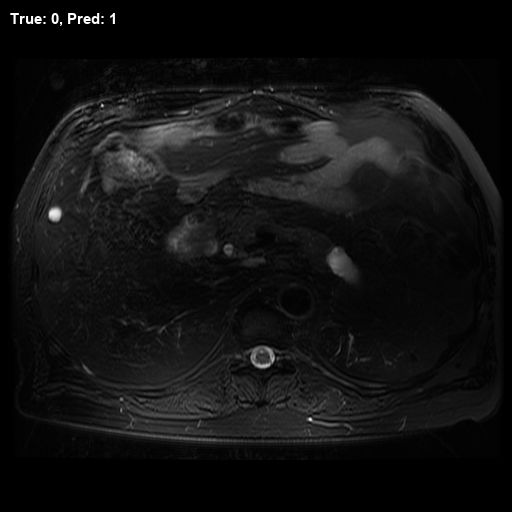

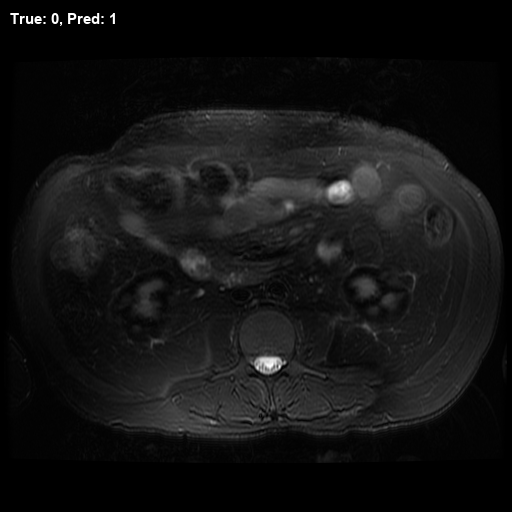

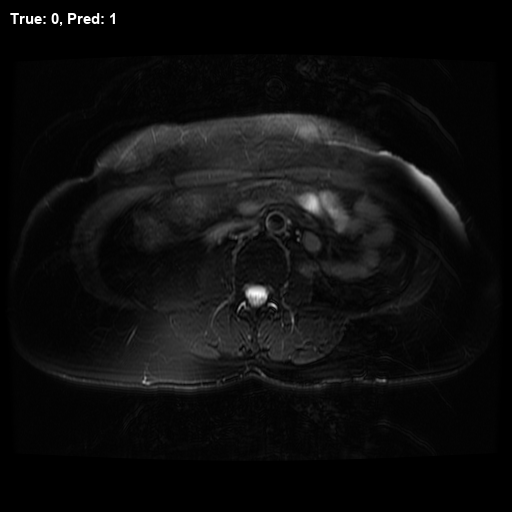

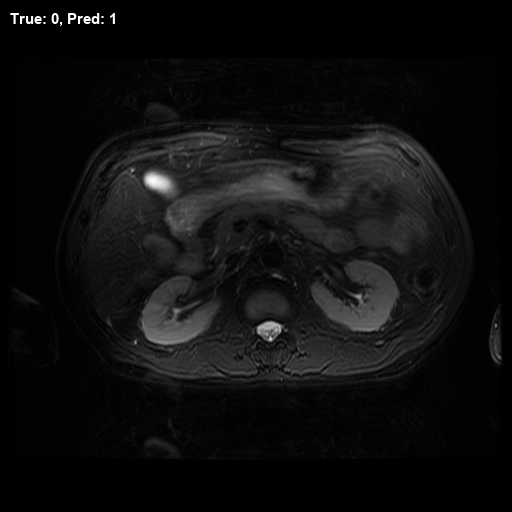

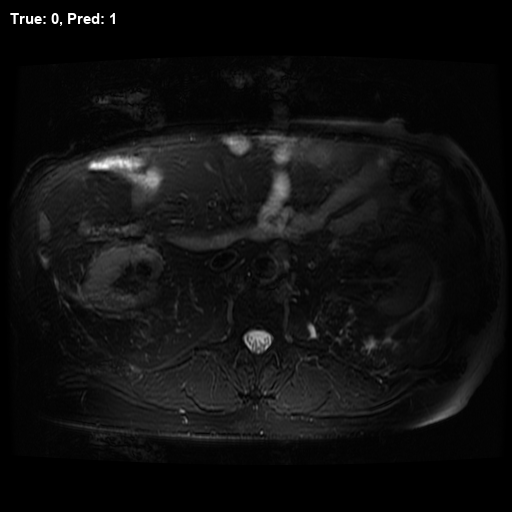

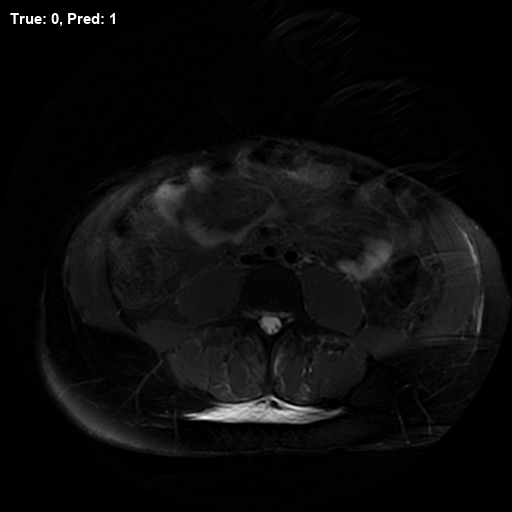

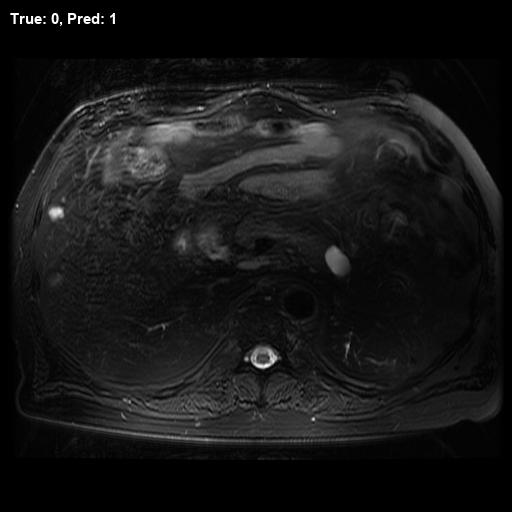

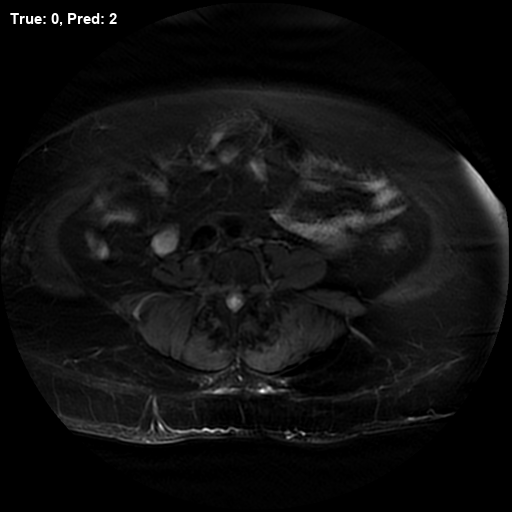

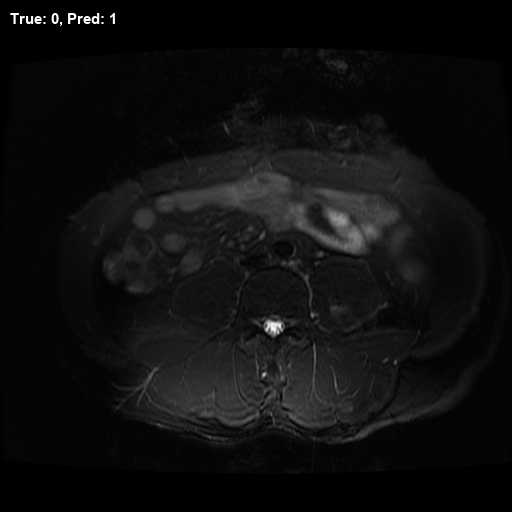

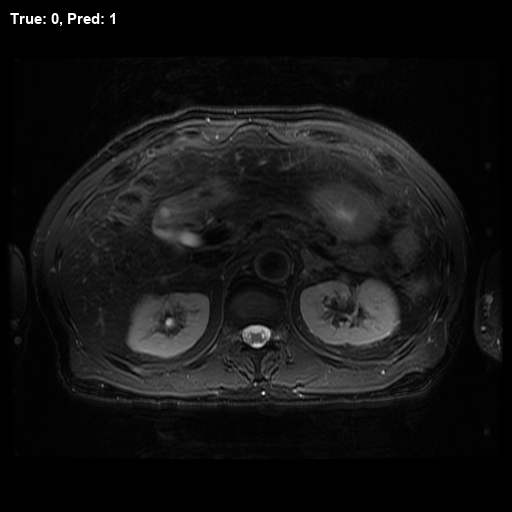

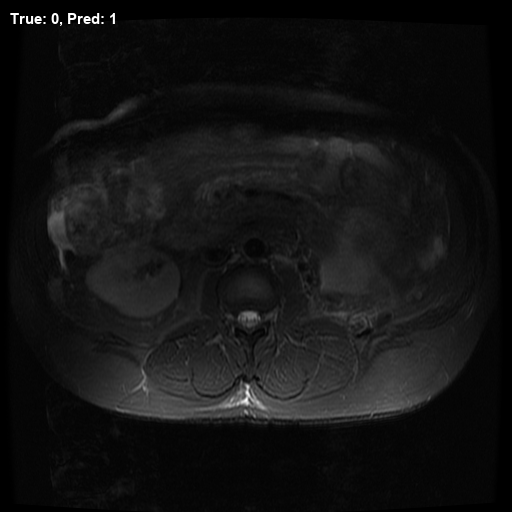

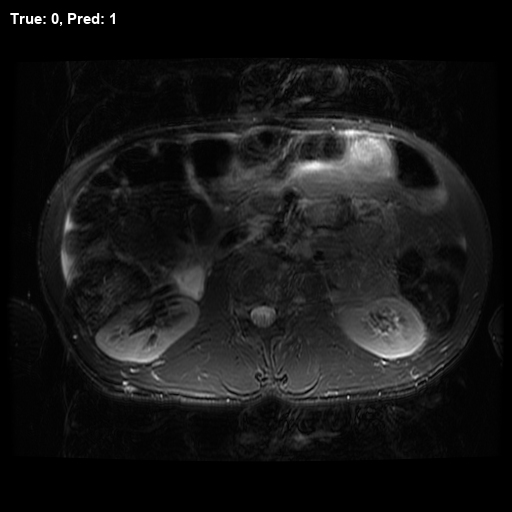

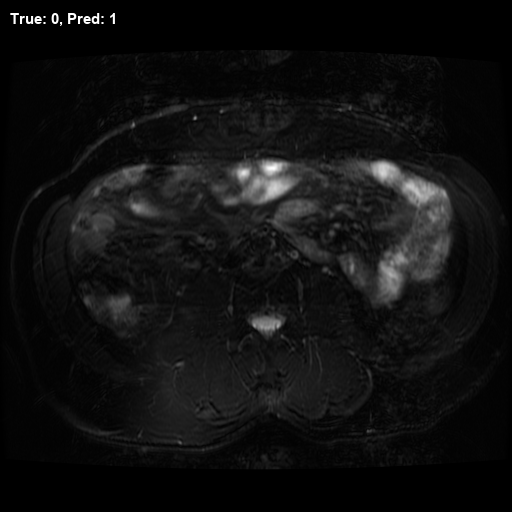

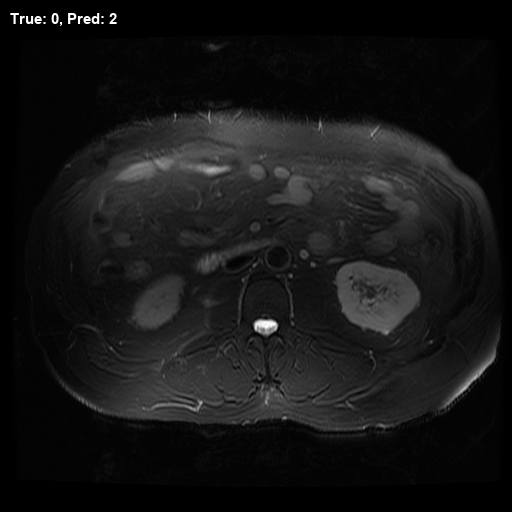

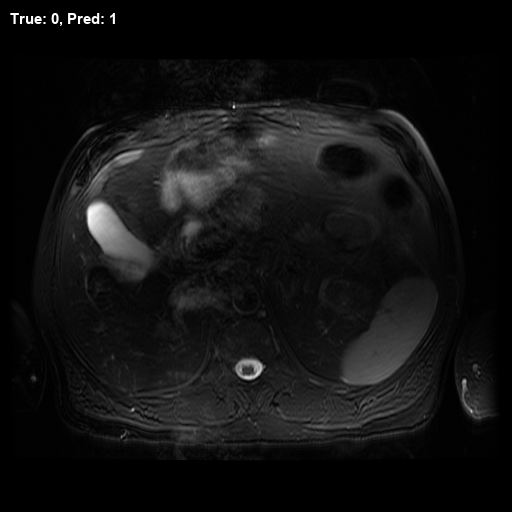

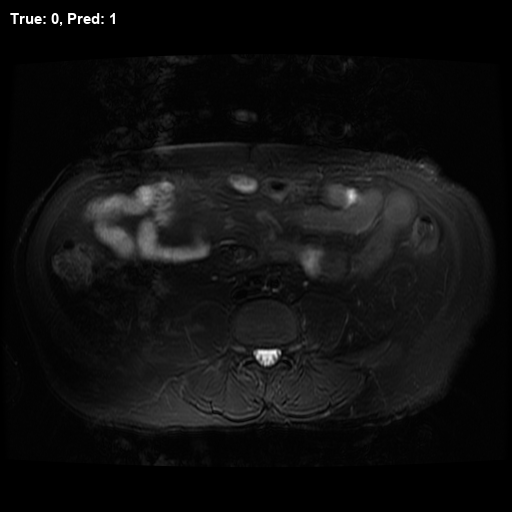

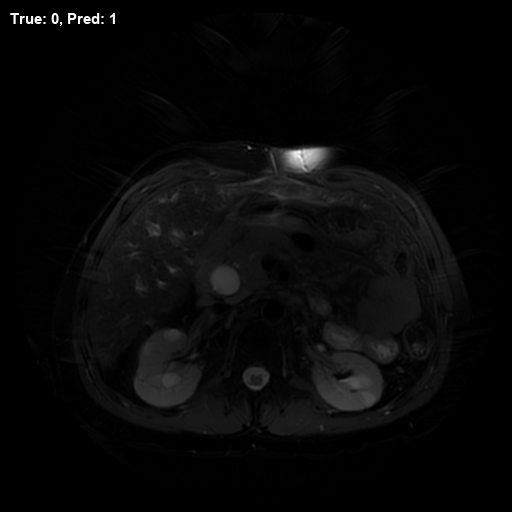

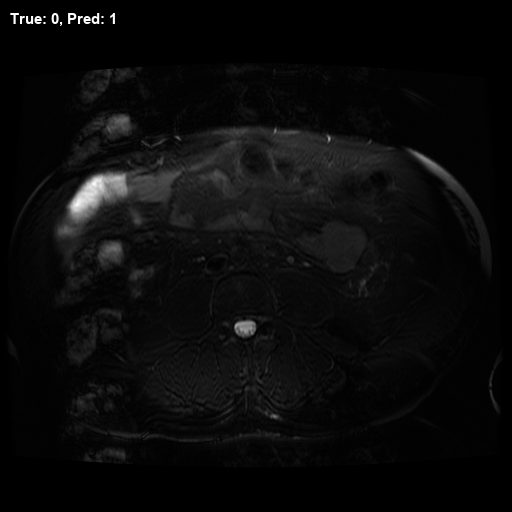

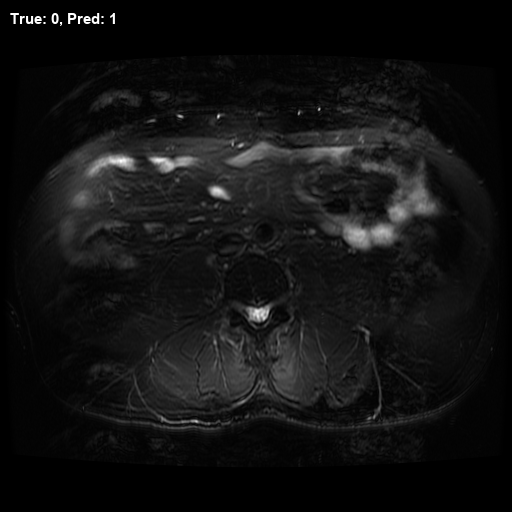

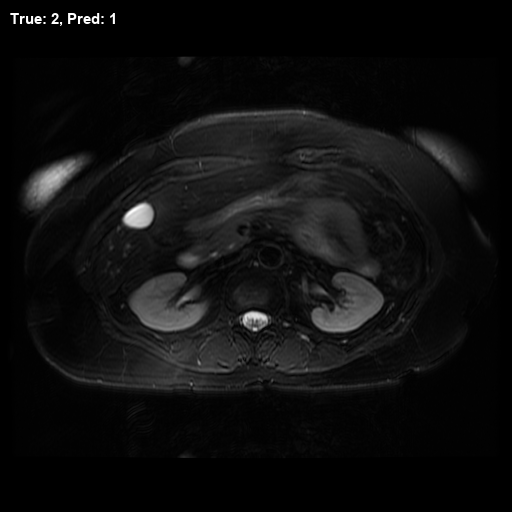

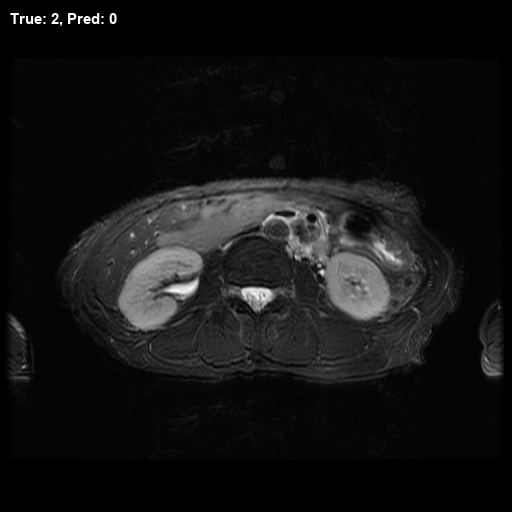

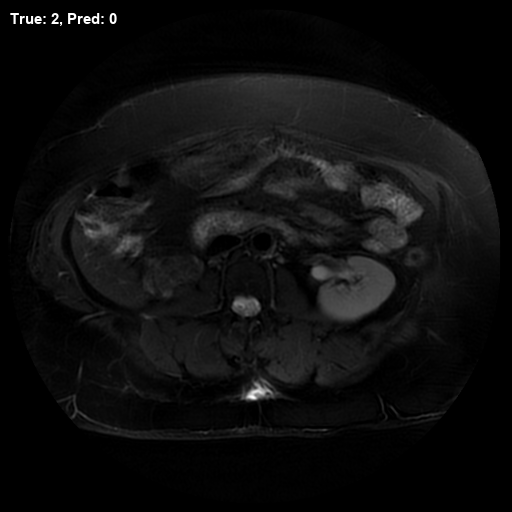

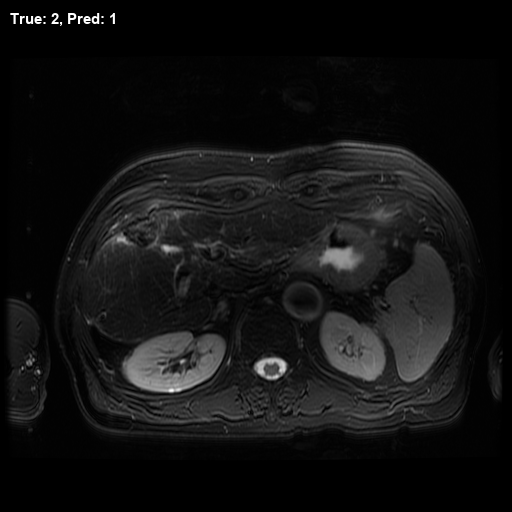

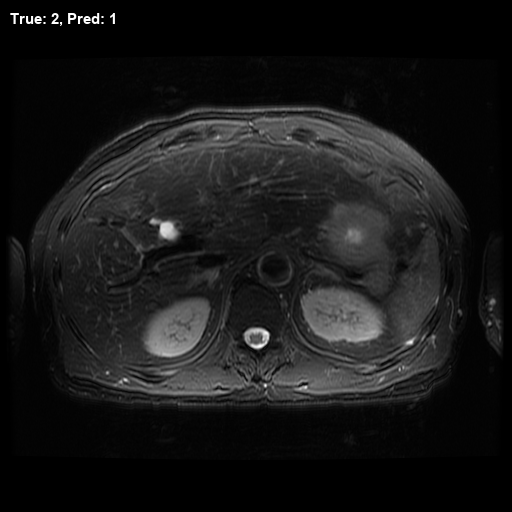

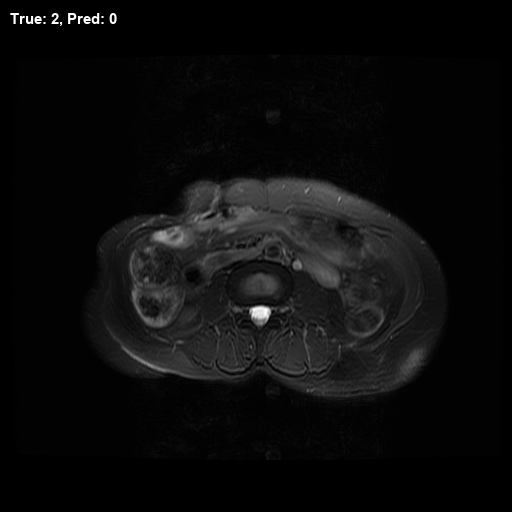

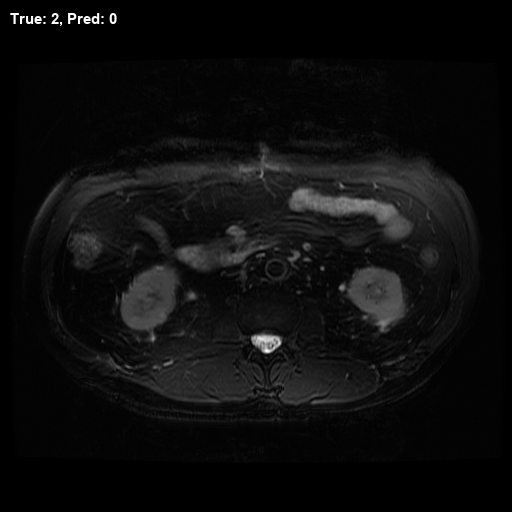

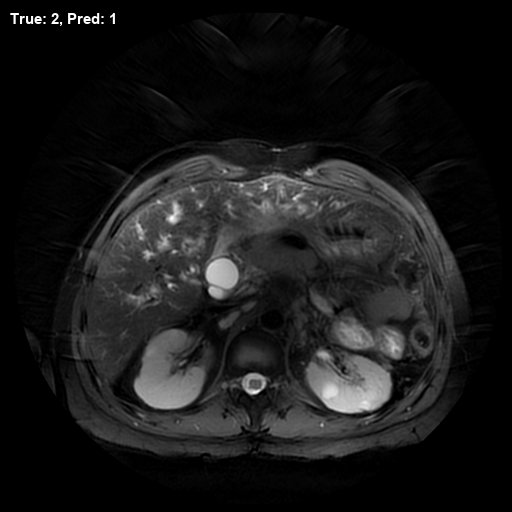

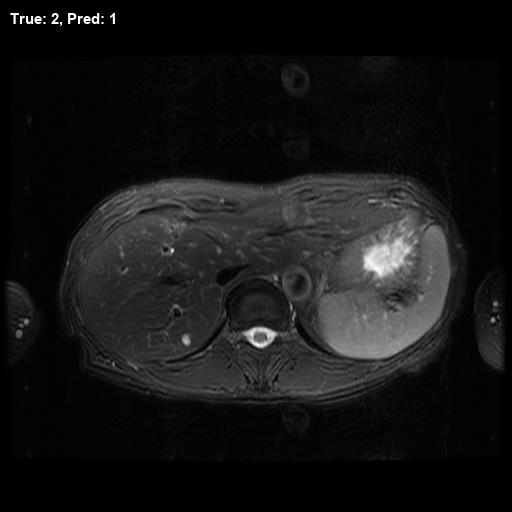

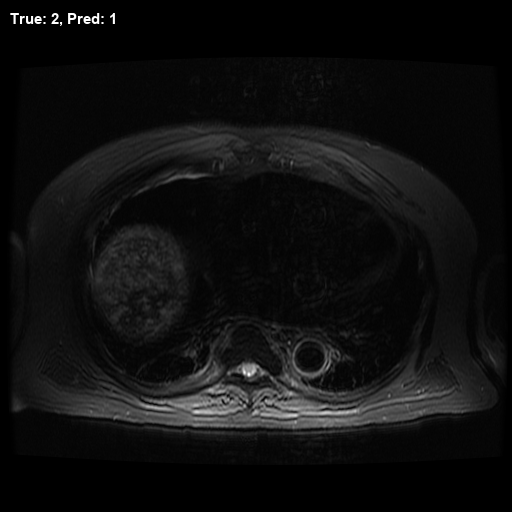

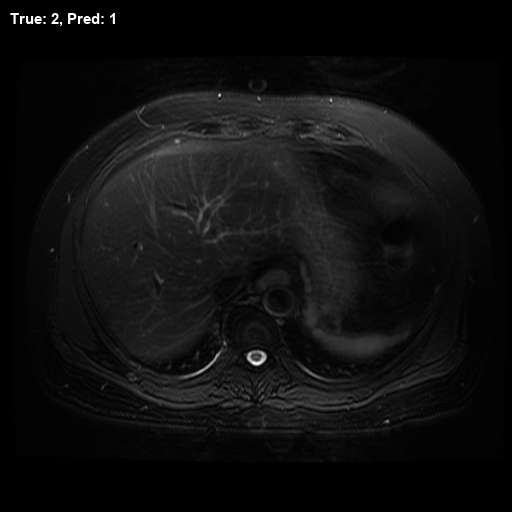

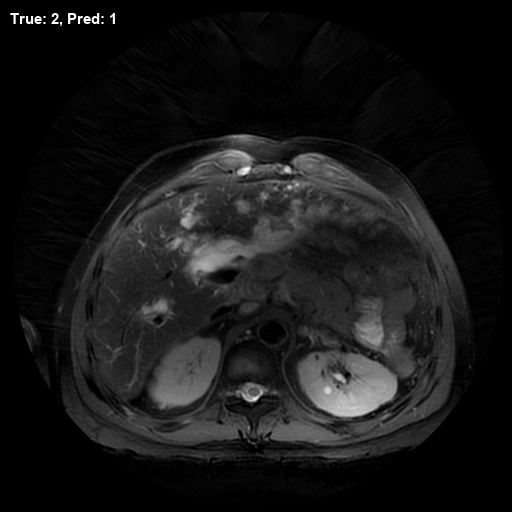

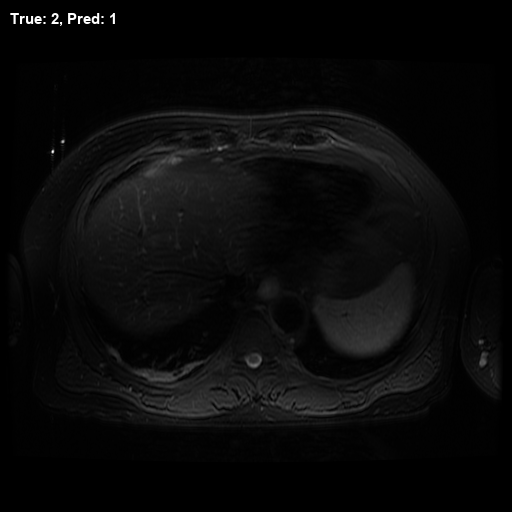

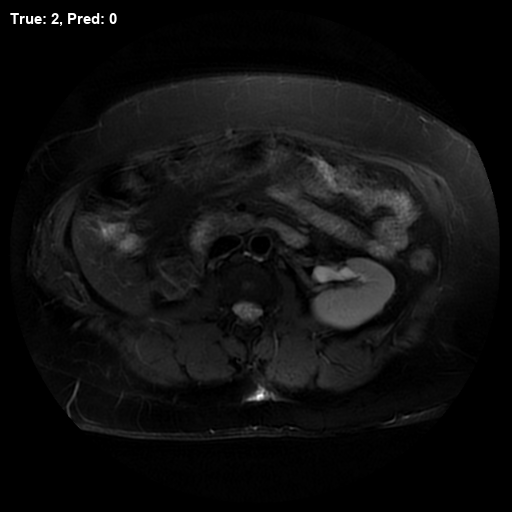

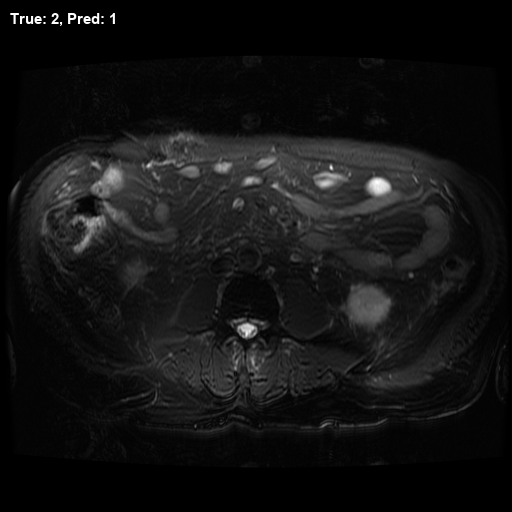

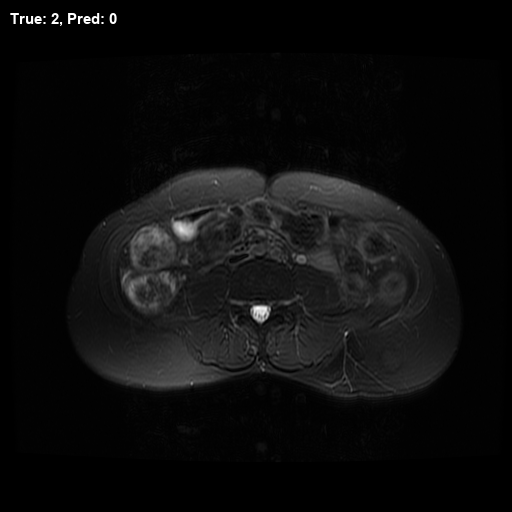

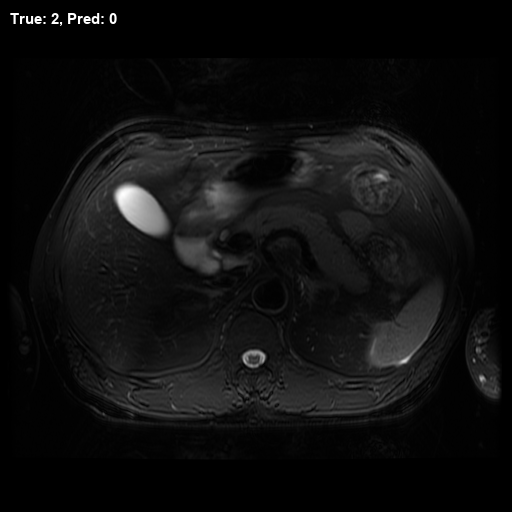

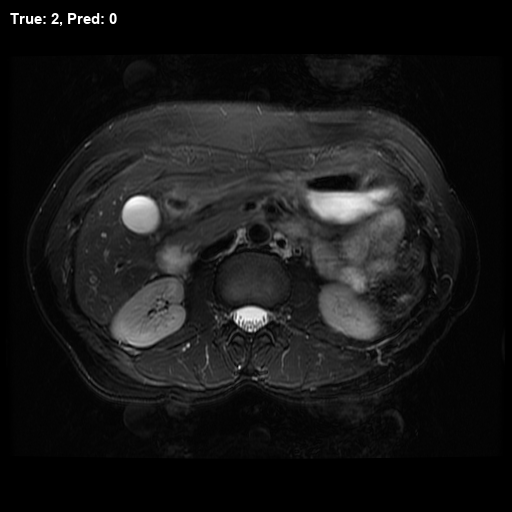

In [15]:
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

convnet_checkpoint_path_base = "/data/jma/model/cnn_v2_rating2/"

dataset_root = "./data/generated_splits/3class_rating2/"

eval_root = dataset_root + dt_set + "/eval/"
eval_paths = load_data_util.load_image_paths(eval_root)

eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, norm=False, shuffle=False)


# change these======
working_paths = eval_paths
working_input_fn = eval_input_fn

kernel_size=[10,7,3,3]
filter_size=16
snnl_weight=0.0
#=========

model_path = convnet_checkpoint_path_base + dt_set + "_filter" + str(filter_size)+"_snnl" + str(snnl_weight) + "/"
print(model_path)


model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                            conv_kernels=kernel_size, 
                                                             num_channels=filter_size,
                                                            snnl_weight=snnl_weight,
                                                            log=False)
model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

values = model.predict(eval_input_fn)

original_labels = path_to_label(eval_paths, dataset_root + dt_set + "/eval/")
predicted_labels = list(values)

# make a plot?


count = 10


counter = 0
for index in range(len(working_paths)):
    if original_labels[index] != predicted_labels[index]["class_ids"][0]:
        # add image to plot

#         if ((original_labels[index] == 0 and predicted_labels[index]["class_ids"][0] == 1) or 
#             (original_labels[index] == 1 and predicted_labels[index]["class_ids"][0] == 2) or
#             (original_labels[index] == 1 and predicted_labels[index]["class_ids"][0] == 0)):
        
        img = Image.open(working_paths[index])

        basewidth = 512

        wpercent = (basewidth/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((basewidth,hsize), Image.ANTIALIAS)


        d = ImageDraw.Draw(img)

        # debug this shit
        d.text((10,10), "True: " + str(original_labels[index]) + 
               ", Pred: " + str(predicted_labels[index]["class_ids"][0]), 
               fill="white", font=ImageFont.truetype("./fonts/arial-bold.ttf", 15))       

        display(img)
    

# ROC Curves

/data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/
./data/generated_splits/2class/ali_relabeled_original/eval/
{'0': 0, '1': 1, '2': 2}
pre-processing
in gpu part


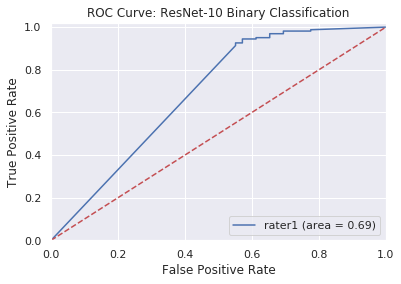

In [19]:
%matplotlib inline

import sklearn

tf.logging.set_verbosity(tf.logging.FATAL)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp
from scipy.interpolate import interp1d




tf.summary.FileWriterCache.clear()
b_size = 32


random_seed = 777

resnet_checkpoint_path_base = "/data/jma/model/resnet10_binary/"


# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

filter_sizes = [16]
snnl_weights = [0.0]

# data_root = "./data/data_relabeled_png_synthetic/"

# image_paths = load_data_util.load_image_paths(data_root)
# train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed, split=[0.7, 0.1, 0.2])

# train_input_fn = lambda : load_data_util.load(data_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
# eval_input_fn = lambda : load_data_util.load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
# test_input_fn = lambda : load_data_util.load(data_root, test_paths, training=False, augment=False, shuffle=False)

        
dataset_root = "./data/generated_splits/2class/"

# sets = ["ali_relabeled_original", "peter_relabeled_original", "ali_relabeled_undersampled", "peter_relabeled_undersampled"]

# sets = ["ali_relabeled_original", "ali_relabeled_undersampled"]
# set_labels = ["rater1", "rater1_undersampled"]

sets = ["ali_relabeled_original"]
set_labels = ["rater1"]

plt.figure()

for dt_set, set_label in zip(sets, set_labels):
    for filter_size in filter_sizes:
        for kernel_size in kernel_sizes:

            for snnl_weight in snnl_weights:

                
#                 eval_root = dataset_root + dt_set + "/test/"
#                 eval_paths = load_data_util.load_image_paths(eval_root)
                
#                 eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, norm=False, shuffle=False)


                
#                 model_path = resnet_checkpoint_path_base + dt_set + "_filter" + str(filter_size)+"_snnl" + str(snnl_weight) + "/"
#                 print(model_path)


#                 model_fn = lambda features, labels, mode: resnet_model_fn(features, labels, mode,
#                                                                              num_channels=filter_size,
#                                                                             snnl_weight=snnl_weight,
#                                                                             log=False)

#                 model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

               
#                 values = model.predict(eval_input_fn)


#                 original_labels = path_to_label(eval_paths, eval_root)
#                 predictions = list(values)
                
#                 predicted_labels = [elem['class_ids'][0] for elem in predictions]
            
#                 tpr_list = dict()
#                 fpr_list = dict()
#                 roc_auc = dict()
                
#                 plt.title('ROC Curves: ResNet 3-Class Classification')
#                 plt.plot([0, 1], [0, 1], 'r--')
#                 plt.xlim([0.0, 1.0])
#                 plt.ylim([0.0, 1.02])
#                 plt.xlabel('False Positive Rate')
#                 plt.ylabel('True Positive Rate')

                
                
#                 for i in range(3):
                    
#                     def get_positive_label(x, comp):
#                         if x == comp:
#                             return 1
#                         else:
#                             return 0
                    
#                     positive_true_label = [get_positive_label(label, i) for label in original_labels]
#                     postitive_predicted_probabilities = [elem["probabilities"][i] for elem in predictions]

                
#                     fpr, tpr, thresholds = sklearn.metrics.roc_curve(positive_true_label, postitive_predicted_probabilities)
                    
#                     tpr_list[i] = tpr
#                     fpr_list[i] = fpr
                    
#                     auc = sklearn.metrics.roc_auc_score(positive_true_label, postitive_predicted_probabilities)

#                     roc_auc[i] = auc
                    
                
#                     plt.plot(fpr, tpr, label= 'label ' + str(i) + ' (area = %0.2f)' % auc)
                    
                

#                 # binarized:
                
#                 def get_diagnostic_label(label):
#                     if label > 0:
#                         return 1
#                     else:
#                         return 0
                
#                 positive_true_label = [get_diagnostic_label(label) for label in original_labels]
#                 postitive_predicted_probabilities = [elem["probabilities"][i] for elem in predictions]
#                 fpr, tpr, thresholds = sklearn.metrics.roc_curve(positive_true_label, postitive_predicted_probabilities)
#                 auc = sklearn.metrics.roc_auc_score(positive_true_label, postitive_predicted_probabilities)
   
# #                 plt.plot(fpr, tpr, label= 'binarized (area = %0.2f)' % auc)
#                 plt.legend(loc="lower right")

                
                

                   
                
#                 plt.show()

                eval_root = dataset_root + dt_set + "/eval/"
                eval_paths = load_data_util.load_image_paths(eval_root)
                
                eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, norm=False, shuffle=False)


                
                model_path = resnet_checkpoint_path_base + dt_set + "_filter" + str(filter_size)+"_snnl" + str(snnl_weight) + "/"
                print(model_path)


                model_fn = lambda features, labels, mode: resnet_model_fn(features, labels, mode, 
                                                                             num_channels=filter_size,
                                                                            snnl_weight=snnl_weight,
                                                                            log=False)

                model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

               
                values = model.predict(eval_input_fn)


                original_labels = path_to_label(eval_paths, eval_root)
                predictions = list(values)
                
                predicted_labels = [elem['class_ids'][0] for elem in predictions]
                
                predicted_probabilities = [elem["probabilities"][1] for elem in predictions]
                
        
                
                fpr, tpr, thresholds = sklearn.metrics.roc_curve(original_labels, predicted_probabilities)

                auc = sklearn.metrics.roc_auc_score(original_labels, predicted_probabilities)
                
                
                plt.plot(fpr, tpr, label= set_label + ' (area = %0.2f)' % auc)
                plt.plot([0, 1], [0, 1], 'r--')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.02])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve: ResNet-10 Binary Classification')
                plt.legend(loc="lower right")
                plt.show()

                    
      
                
 



                
                

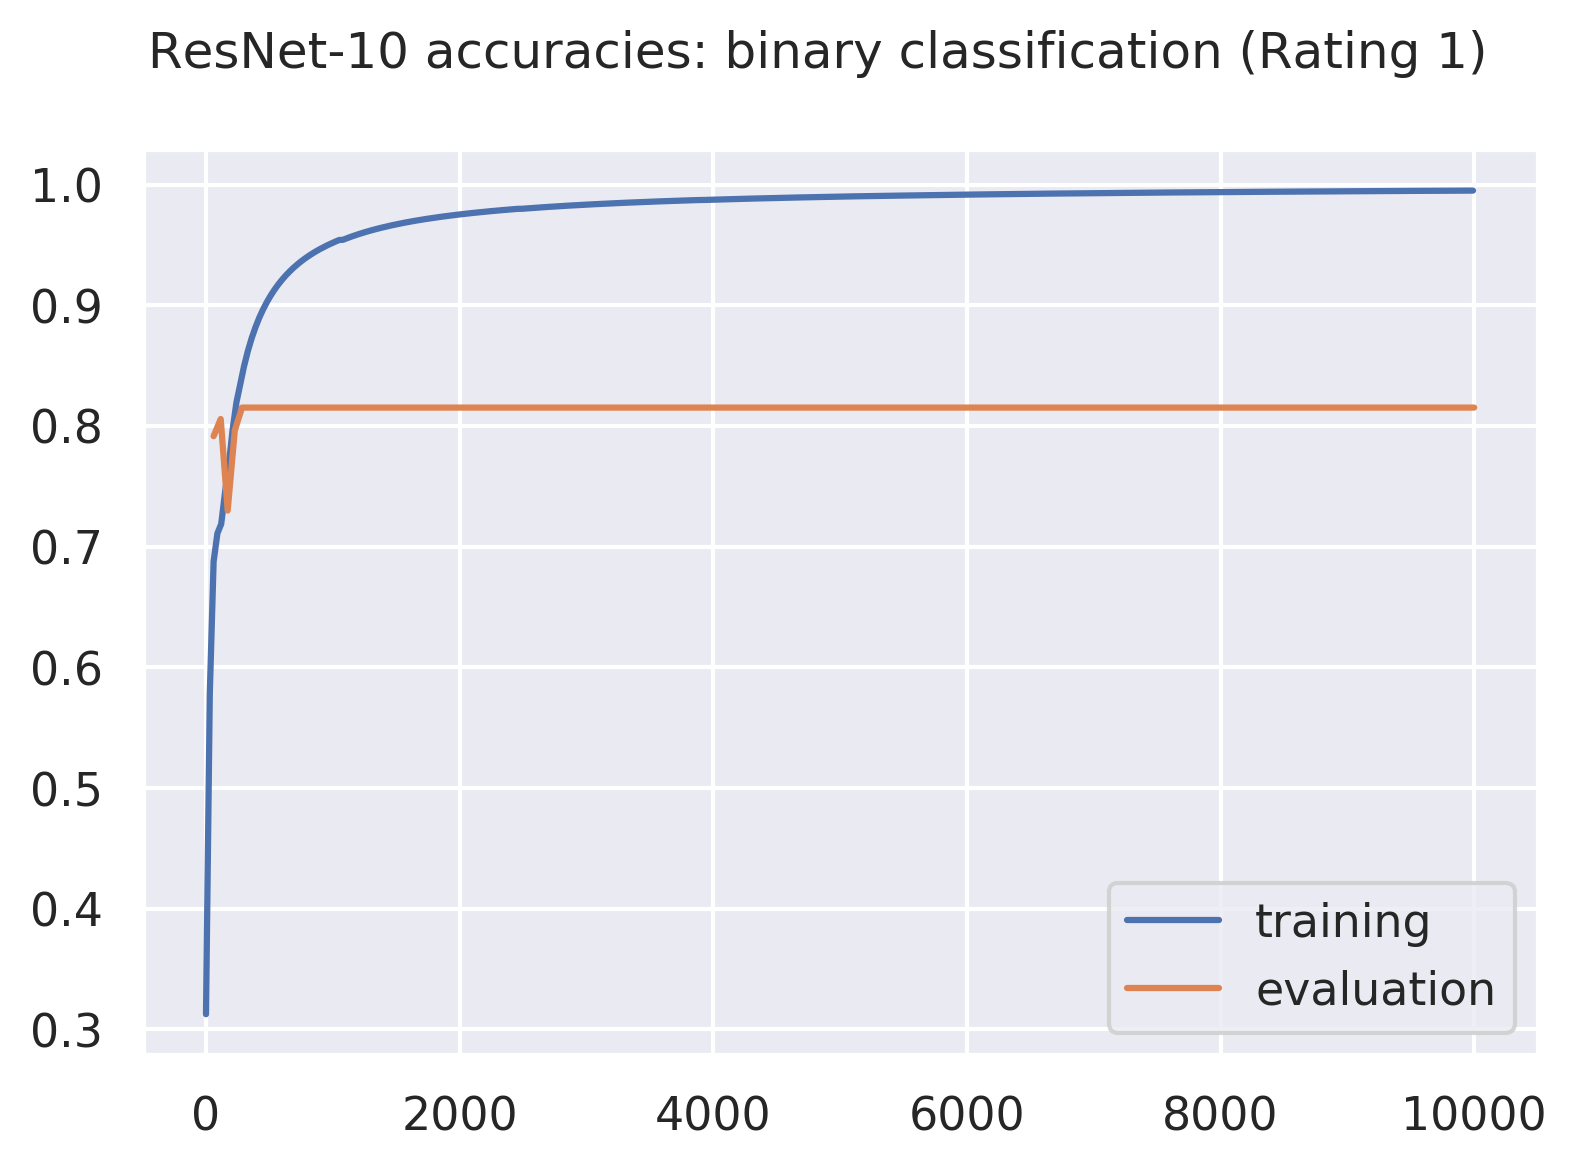

In [20]:
import tensorboard

event_files = ["/data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/events.out.tfevents.1569357662.mrlearning"]
# event_files = ["/data/jma/model/cnn_v2_rating2/ali_relabeled_original_filter16_snnl0.0/events.out.tfevents.1567044165.mrlearning"]
      
    
accuracy_list= []
loss_list = []

for event_file in event_files:
    for event in tf.train.summary_iterator(event_file):
        for v in event.summary.value:
            if (v.tag == 'accuracy_1'):
                accuracy_list.append([event.step, v.simple_value])
            elif (v.tag == 'loss'):
                loss_list.append([event.step, v.simple_value])
# smoothing

        

fig = plt.figure(dpi=300)        
plt.plot([elem[0] for elem in accuracy_list], [elem[1] for elem in accuracy_list], label="training")


# event_files = ["/data/jma/model/cnn_v2_rating1/ali_relabeled_undersampled_filter16_snnl0.0/events.out.tfevents.1566889336.mrlearning"]
# accuracy_list= []
# loss_list = []

# for event_file in event_files:
#     for event in tf.train.summary_iterator(event_file):
#         for v in event.summary.value:
#             if (v.tag == 'accuracy_1'):
#                 accuracy_list.append([event.step, v.simple_value])
#             elif (v.tag == 'loss'):
#                 loss_list.append([event.step, v.simple_value])
            
# plt.plot([elem[0] for elem in accuracy_list], [elem[1] for elem in accuracy_list], label="rater1_undersampled_train")


event_files = ["/data/jma/model/resnet10_binary/ali_relabeled_original_filter16_snnl0.0/eval/events.out.tfevents.1569357699.mrlearning"]
      
    
# event_files = ["/data/jma/model/cnn_v2_rating2/ali_relabeled_original_filter16_snnl0.0/eval/events.out.tfevents.1567044200.mrlearning"]
      
       
accuracy_list= []
loss_list = []

for event_file in event_files:
    for event in tf.train.summary_iterator(event_file):
        for v in event.summary.value:
            if (v.tag == 'accuracy'):
                accuracy_list.append([event.step, v.simple_value])
            elif (v.tag == 'loss'):
                loss_list.append([event.step, v.simple_value])
# smoothing

                
plt.plot([elem[0] for elem in accuracy_list], [elem[1] for elem in accuracy_list], label="evaluation")


# event_files = ["/data/jma/model/cnn_v2_rating1/ali_relabeled_undersampled_filter16_snnl0.0/eval/events.out.tfevents.1566889370.mrlearning"]

# accuracy_list= []
# loss_list = []

# for event_file in event_files:
#     for event in tf.train.summary_iterator(event_file):
#         for v in event.summary.value:
#             if (v.tag == 'accuracy'):
#                 accuracy_list.append([event.step, v.simple_value])
#             elif (v.tag == 'loss'):
#                 loss_list.append([event.step, v.simple_value])
            
# plt.plot([elem[0] for elem in accuracy_list], [elem[1] for elem in accuracy_list], label="rater1_undersampled_eval")

plt.legend()
plt.suptitle("ResNet-10 accuracies: binary classification (Rating 1)")
plt.show()

        
    